In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

import sklearn as skl
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

import tensorflow.keras as K
import tensorflow_hub as hub
import tensorflow as tf
from official.nlp.bert import tokenization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import eli5
from eli5.sklearn import PermutationImportance
from eli5.lime import TextExplainer

import shap

import re
import string

from MyClasses import *

import gc


/home/jeremy/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/jeremy/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [88]:
def define_color_map(colors = [(0x1f, 0x77, 0xb4),(0xEE, 0xEE, 0xEE),(0xff,0x7f,0x0e)], n_intermediary_colors = 4):
    h = 1/n_intermediary_colors
    x = np.arange(0,1,h)
    c1 = np.array([np.array(colors[0])*(1-y) + y*np.array(colors[1]) for y in x])
    c2 = np.array([np.array(colors[1])*(1-y) + y*np.array(colors[2]) for y in x])
    cm = np.concatenate([c1,c2])
    cm = ListedColormap(cm/256)
    return cm

def plot_final_proba(predict_proba, y, final_model=None):
    h = 0.02
    cm = define_color_map()
    x_min, x_max , y_min, y_max = 0, 1.01, 0, 1.01

    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('#f5fafa')

    if final_model is not None:
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = final_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] ; Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.7)

    print(predict_proba.shape)

    data = pd.DataFrame()
    data['model_0'] = predict_proba[:,0]
    data['model_1'] = predict_proba[:,1]
    data['target'] = y.reset_index(drop=True).iloc[:]

    sns.scatterplot(x='model_0', y='model_1', data=data, hue='target')

    x = np.linspace(0,1,100)
    y = np.linspace(0,1,100)
    plt.plot(x, 0.5*np.ones(100), c='k')
    plt.plot(0.5*np.ones(100), y, c='k')
    
    return fig

# Load Data

In [3]:
data_set = pd.read_csv('./train.csv')
test_set = pd.read_csv('./test.csv')

In [4]:
data_set.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_set.shape

(7613, 5)

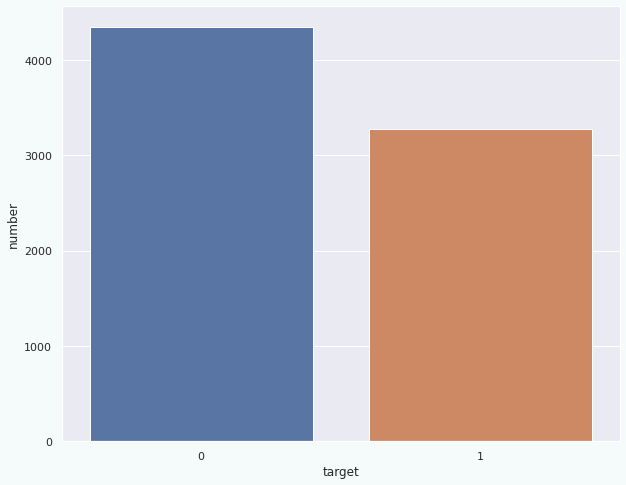

In [6]:
# check size of the classes
fig = plt.figure(figsize=(10,8))
sns.barplot(x='target', y=0, data=pd.DataFrame(data_set.groupby('target').size().reset_index()))
plt.ylabel('number')
fig.patch.set_facecolor('#f5fafa')
plt.savefig("./figures/count_sample_inclass.png")

As we can see above, a lot a the values in 'location' and 'keyword' contain NaN.

Below we show that there are also values in the feature 'location' that have value containing "?" which we will treat as NaN

In [7]:
def f(s):
    if type(s)==str:
        return bool(re.search("[?]+", s))
    else:
        return False
    
# check where we have NaN values
print(data_set.isna().sum(axis=0),'\n')
                     
if_question_mark = data_set['location'].map(lambda s: f(s))

data_set.loc[if_question_mark,'location'].iloc[:10]


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 



111         Somewhere Only We Know ?
216       V-RP @OZRP_ ?MV, AU, R18+?
251    CA physically- Boston Strong?
254    CA physically- Boston Strong?
379                               ? 
496         london / st catharines ?
513               ??????????????????
724    dmv ?? fashion school @ KSU. 
758                        ?205?478?
767            california mermaid ? 
Name: location, dtype: object

We remove all the NaN

In [8]:
# fill Nan in location with no_location and Nan in keywords with no_keyword

def remove_Qmarks(s):
    if type(s)==type('') and bool(re.search("[?]", s)):
        s = np.nan
    return s

data_set['keyword'] = data_set['keyword'].map(lambda s: remove_Qmarks(s) ) 
data_set['location'] = data_set['location'].map(lambda s: remove_Qmarks(s) ) 

test_set['keyword'] = test_set['keyword'].map(lambda s: remove_Qmarks(s) ) 
test_set['location'] = test_set['location'].map(lambda s: remove_Qmarks(s) ) 

data_set = data_set.fillna(value={'keyword':'no_keyword', 'location':'no_location'})
test_set = test_set.fillna(value={'keyword':'no_keyword', 'location':'no_location'})
data_set.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print(f'Number of unique values in keyword = {data_set["keyword"].nunique()} (Training) - {test_set["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {data_set["location"].nunique()} (Training) - {test_set["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3221 (Training) - 1541 (Test)


In [10]:
# check that key words are the same in test set and train set

data_set['keyword'].unique() == test_set['keyword'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [11]:
#Too many unique location, we will drop the location column

data_set = data_set.drop('location', axis=1)
test_set = test_set.drop('location', axis=1)


There are some tweets that appear several time in the data set. Some of these have different label. 

Below we modify the label of these tweets so that all the copies of a tweet have the same label.

In [12]:
# checking mislabeled text: identical tweets labeled differently

data_mislabeled = data_set.loc[:,['text', 'target']].groupby(['text']).nunique().sort_values(by='target', ascending=False)
data_mislabeled = data_mislabeled.loc[data_mislabeled['target']>1]

mislabeled_bool = data_set['text'].map(lambda s: s in list(data_mislabeled.index)) ; del data_mislabeled

new_target = data_set.loc[:,['text', 'target']].groupby('text').mean()  # use voting strategy to relabel the mislabeled tweet
new_target = new_target['target'].map(lambda avg: int(avg>0.5))  # use voting strategy to relabel the mislabeled tweet

# if mislabeld then 'new_target' otherwise 'target'
data_set['target_corrected'] = np.array(new_target.loc[data_set['text']])*np.array(mislabeled_bool)+np.array(data_set['target'])*(1-np.array(mislabeled_bool))



Finally we clean the tweets, so that it becomes easier for the ML model to work.

In [13]:
%%time

def clean(tweet): 
    
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
                
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "url", tweet)
    
     # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    #Typos
    tweet = re.sub(r"[Aa]mageddon", "armageddon", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)    
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
     
    

    # Hashtags and usernames
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"Bioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
    
    
    # informal abbreviations, slang
    if re.findall(r"NASA\w+", tweet):
        tweet = re.sub(r"NASA", "NASA ", tweet)
    if re.findall(r"USA\w+", tweet):
        tweet = re.sub(r"USA", "USA ", tweet)
    if re.findall(r"MTV\w+", tweet):
        tweet = re.sub(r"MTV", "MTV ", tweet)
    if re.findall(r"UK\w+", tweet):
        tweet = re.sub(r"UK", "UK ", tweet)        
    tweet = re.sub(r"[gG]ov.?", "government", tweet)
    tweet = re.sub(r"[lL][mM][aA][oO]", "laughing my ass off", tweet)   
    tweet = re.sub(r"[oO][.\s]?[mM][.\s]?[gG]", "oh my god", tweet)
    tweet = re.sub(r"[Ww]/e", "whatever", tweet)
    tweet = re.sub(r"[Ww]/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"U\b", "You", tweet)
    tweet = re.sub(r"[tT]rfc", "traffic", tweet)    
    tweet = re.sub(r"[Yy][Ee]+[Ss]+", "yes", tweet)

        
    # split word glued together when start with capital, eg, ThisIsFunny -> This Is Funny or thisIsFunny -> this Is Funny
    def concat(L, separator=" "):
        '''Takes a list of strings and concat them with separator'''
        concat=""
        for word in L:
            concat += word+separator
        return concat[:-1] #remove the last separator
    
    words = tweet.split()
    exceptions = ["YouTube"]
    for idx, word in enumerate(words):
        if re.findall(r"\B[A-Z][a-z]+", word) and not (word in exceptions):
            L = re.findall(r"[A-Za-z][a-z]+", word)
            words[idx] = concat(L) 
    tweet = concat(words)

    
    # lowercase the tweet
    tweet = tweet.lower()
    
    # Contractions
    tweet = re.sub(r"he['\s]?s\b", "he is", tweet)
    tweet = re.sub(r"there['\s]?s\b", "there is", tweet)
    tweet = re.sub(r"we['\s]?re\b", "we are", tweet)
    tweet = re.sub(r"that['\s]?s\b", "that is", tweet)
    tweet = re.sub(r"won['\s]?t\b", "will not", tweet)
    tweet = re.sub(r"they['\s]?re\b", "they are", tweet)
    tweet = re.sub(r"can['\s]?t\b", "Cannot", tweet)
    tweet = re.sub(r"wasn['\s]?t\b", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt\b", "do not", tweet)
    tweet = re.sub(r"aren['\s]?t\b", "are not", tweet)
    tweet = re.sub(r"isn['\s]?t\b", "is not", tweet)
    tweet = re.sub(r"what['\s]?s\b", "What is", tweet)
    tweet = re.sub(r"haven['\s]?t\b", "have not", tweet)
    tweet = re.sub(r"hasn['\s]?t\b", "has not", tweet)
    tweet = re.sub(r"there['\s]?s\b", "There is", tweet)
    tweet = re.sub(r"he['\s]?s\b", "He is", tweet)
    tweet = re.sub(r"it['\s]s\b", "It is", tweet)
    tweet = re.sub(r"you['\s]?(re)\b", "You are", tweet)
    tweet = re.sub(r"i['\s]?m\b", "I am", tweet)
    tweet = re.sub(r"shouldn['\s]?t\b", "should not", tweet)
    tweet = re.sub(r"wouldn['\s]?t\b", "would not", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"\bi['\s]?m\b", "i am", tweet)
    tweet = re.sub(r"isn['\s]?t\s?", "is not", tweet)
    tweet = re.sub(r"here['\s]?s\b", "here is", tweet)
    tweet = re.sub(r"you['\s]?ve\b", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we['\s]re\b", "we are", tweet)
    tweet = re.sub(r"what['\s]?s\b", "what is", tweet)
    tweet = re.sub(r"couldn['\s]?t\b", "could not", tweet)
    tweet = re.sub(r"we['\s]?ve\b", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"here\x89Ûªs", "here is", tweet)
    tweet = re.sub(r"who['\s]s\b", "who is", tweet)
    tweet = re.sub(r"\bi\x89Ûªve", "i have", tweet)
    tweet = re.sub(r"\by['\s]?all\b", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've\b", "would have", tweet)
    tweet = re.sub(r"it['\s]?ll\b", "it will", tweet)
    tweet = re.sub(r"we['\s]?ll\b", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"we['\s]?ve\b", "We have", tweet)
    tweet = re.sub(r"he['\s]ll\b", "he will", tweet)
    tweet = re.sub(r"weren['\s]?t\b", "were not", tweet)
    tweet = re.sub(r"didn['\s]?t\b", "did not", tweet)
    tweet = re.sub(r"they['\s]?ll\b", "they will", tweet)
    tweet = re.sub(r"they['\s]?d\b", "they would", tweet)
    tweet = re.sub(r"don['\s]?t\b", "do not", tweet)
    tweet = re.sub(r"that\x89Ûªs\b", "That is", tweet)
    tweet = re.sub(r"they['\s]?ve\b", "they have", tweet)
    tweet = re.sub(r"should['\s]?ve\b", "should have", tweet)
    tweet = re.sub(r"you\x89Ûªre\b", "You are", tweet)
    tweet = re.sub(r"where[']?s\b", "where is", tweet)
    tweet = re.sub(r"don\x89Ûªt\b", "Do not", tweet)
    tweet = re.sub(r"we['\s]d\b", "we would", tweet)
    tweet = re.sub(r"\bi['\s]ll\b", "i will", tweet)
    tweet = re.sub(r"weren['\s]?t\b", "were not", tweet)
    tweet = re.sub(r"they['\s]?re\b", "They are", tweet)
    tweet = re.sub(r"can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"\bi\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let['\s]s\b", "let us", tweet)
    tweet = re.sub(r"it['\s]s\b", "it is", tweet)
    tweet = re.sub(r"can[\s']?t\b", "cannot", tweet)
    tweet = re.sub(r"you[\s']?re\b", "you are", tweet)
    tweet = re.sub(r"that['\s]?s\b", "that is", tweet)
    tweet = re.sub(r"doesn[\s']?t\b", "does not", tweet)
    tweet = re.sub(r"didn[\s']?t\b", "did not", tweet)
    tweet = re.sub(r"you[\s']?ll\b", "you will", tweet)
    tweet = re.sub(r"\bi[\s']?ve\b", "I have", tweet)
    tweet = re.sub(r"don[\s']?t\b", "do not", tweet)
    tweet = re.sub(r"\bi[\s']?ll\b", "I will", tweet)
    tweet = re.sub(r"\bi[\s']?d\b", "I would", tweet)
    tweet = re.sub(r"you[\s']?d\b", "you would", tweet)
    tweet = re.sub(r"it['\s]s\b", "It is", tweet)
    tweet = re.sub(r"ain[\s']?t\b", "am not", tweet)
    tweet = re.sub(r"haven[\s']?t\b", "have not", tweet)
    tweet = re.sub(r"could['\s]?ve\b", "could have", tweet)
    tweet = re.sub(r"you[\s']?ve\b", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)
    
    #lowercase tweet
    tweet = tweet.lower()
    

    
    # Time format, eg, 5:45pM -> 5:45 PM 
    L = re.findall("(\d{0,2}:?\d{1,2}[Pp][Mm])|(\d{0,2}:?\d{1,2}[aA][Mm])", tweet)
    for textPM, textAM in L: 
        if textPM: tweet = re.sub(textPM,textPM[:-2]+" pm",tweet)
        if textAM: tweet = re.sub(textAM, textAM[:-2]+" am", tweet)
            
    
    # eg, 5mins -> 5 minutes
    L = re.findall("(1min)|(\d{1,2}mins)|(1\smin)|(\d{1,2}\smins)|([2-99]min)|([2-99] min)", tweet)
    for text1, text2, text3, text4, text5, text6 in L:
        if text1: tweet = re.sub(text1,"1 minute", tweet)
        if text2: tweet = re.sub(text2,text2[:-4]+" minutes", tweet)
        if text3: tweet = re.sub(text3,"1 minute", tweet)
        if text4: tweet = re.sub(text4,text4[:-4]+"minutes", tweet)
        if text5: tweet = re.sub(text5,text5[:-3]+" minutes", tweet)
        if text6: tweet = re.sub(text6,text6[:-3]+" minutes", tweet)
            
    #eg, Ph0to -> Photo  (0->o in words)
    L = re.findall("[a-z]+0[a-z]+", tweet.lower())
    for text in L:
        text_new = re.sub("0","o", text)
        tweet = re.sub(text, text_new, tweet.lower())            
    

    
    #eg, 50years -> 50 years or 12january ->12 january
    L = re.findall("(\d+[a-z]+)", tweet.lower())
    for text in L:
        nb = re.findall("\d+", text)
        tweet = re.sub(text, nb[0]+' '+text[len(nb)+1:], tweet.lower())
    L = re.findall("([a-z]+\d+)", tweet.lower())
    for text in L:
        nb = re.findall("\d+", text)
        tweet = re.sub(text, text[:-len(nb)-1]+' '+nb[0], tweet.lower()) 
           
    
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^"' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        

    return tweet.lower()


data_set['text_cleaned'] = data_set['text'].apply(lambda s : clean(s))
test_set['text_cleaned'] = test_set['text'].apply(lambda s : clean(s))


CPU times: user 7.59 s, sys: 20 µs, total: 7.59 s
Wall time: 7.61 s


In [14]:
for text, text_cleaned in zip(data_set.loc[:10, 'text'], data_set.loc[:10,'text_cleaned']):
    print(text, '\n', text_cleaned, '\n\n')

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 
 our deeds are the reason of this  # earthquake may allah forgive us all 


Forest fire near La Ronge Sask. Canada 
 forest fire near la ronge sask .  canada 


All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 
 all residents asked to  ' shelter in place '  are being notified by officers .  no other evacuation or shelter in place orders are expected 


13,000 people receive #wildfires evacuation orders in California  
 13,000 people receive  # wildfires evacuation orders in california 


Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  
 just got sent this photo from ruby  # alaska as smoke from  # wildfires pours into a school 


#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 
 rocky fire update  =  >  california hwy .  20 closed

# Add extra features

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data_set[['keyword','text', 'text_cleaned']], 
                                                  data_set['target_corrected'])

We add some extra features to improve the final model. One can for example add hashtag count, mean word length, words count etc.

In [16]:
# count the number of hashtags
X_train['hastags_count'] = X_train['text'].map(lambda text: sum([char=='#' for char in text]) )
X_val['hastags_count'] = X_val['text'].map(lambda text: sum([char=='#' for char in text]) )
test_set['hastags_count'] = test_set['text'].map(lambda text: sum([char=='#' for char in text]) )

# count all cap words
X_train['capital_words_count'] = X_train['text'].map( lambda text: sum( [word==word.upper() for word in text.split()] ) )
X_val['capital_words_count'] = X_val['text'].map( lambda text: sum( [word==word.upper() for word in text.split()] ) )
test_set['capital_words_count'] = test_set['text'].map( lambda text: sum( [word==word.upper() for word in text.split()] ) )

# word_count
X_train['word_count'] = X_train['text'].apply(lambda x: len(str(x).split()))
X_val['word_count'] = X_val['text'].apply(lambda x: len(str(x).split()))
test_set['word_count'] = test_set['text'].apply(lambda x: len(str(x).split()))


# unique_word_count
X_train['unique_word_count'] = X_train['text'].apply(lambda x: len(set(str(x).split())))
X_val['unique_word_count'] = X_val['text'].apply(lambda x: len(set(str(x).split())))
test_set['unique_word_count'] = test_set['text'].apply(lambda x: len(set(str(x).split())))

# url_count
X_train['url_count'] = X_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
X_val['url_count'] = X_val['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_set['url_count'] = test_set['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))


# mean_word_length
X_train['mean_word_length'] = X_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
X_val['mean_word_length'] = X_val['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_set['mean_word_length'] = test_set['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
X_train['char_count'] = X_train['text'].apply(lambda x: len(str(x)))
X_val['char_count'] = X_val['text'].apply(lambda x: len(str(x)))
test_set['char_count'] = test_set['text'].apply(lambda x: len(str(x)))

# punctuation_count
X_train['punctuation_count'] = X_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
X_val['punctuation_count'] = X_val['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_set['punctuation_count'] = test_set['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


# mention_count
X_train['mention_count'] = X_train['text'].apply(lambda s: len(re.findall("\s?@\w+", s)))
X_val['mention_count'] = X_val['text'].apply(lambda s: len(re.findall("\s?@\w+", s)))
test_set['mention_count'] = test_set['text'].apply(lambda s: len(re.findall("\s?@\w+", s)))

# count mentions in classes
mentionCounter = CountMentionsInClass()
X_train = mentionCounter.fit_transform(X_train, y_train, column='text')
X_val = mentionCounter.transform(X_val, column='text')
test_set = mentionCounter.transform(test_set, column='text')

# compute de difference between  mentions in disasters and mentions not in disasters
X_train["difference_mentions_count"] = X_train["count_mentions_in_disaster"] - X_train["count_mentions_in_ndisaster"]
X_val["difference_mentions_count"] = X_val["count_mentions_in_disaster"] - X_val["count_mentions_in_ndisaster"]
test_set["difference_mentions_count"] = test_set["count_mentions_in_disaster"] - test_set["count_mentions_in_ndisaster"]

# count ngram in classes
ngramCounter = CountTopNGramsInClass(n=2)
X_train = ngramCounter.fit_transform(X_train, y_train, column='text')
X_val = ngramCounter.transform(X_val, column='text')
test_set = ngramCounter.transform(test_set, column='text')

# compute de difference between top ngrams in disasters and top ngrams not in disasters
X_train[f"difference_{2}-grams_count"] = X_train["count_2-grams_in_disaster"] - X_train["count_2-grams_in_ndisaster"]
X_val[f"difference_{2}-grams_count"] = X_val["count_2-grams_in_disaster"] - X_val["count_2-grams_in_ndisaster"]
test_set[f"difference_{2}-grams_count"] = test_set["count_2-grams_in_disaster"] - test_set["count_2-grams_in_ndisaster"]

In [17]:
X_val.head(3)

,keyword,text,text_cleaned,hastags_count,capital_words_count,word_count,unique_word_count,url_count,mean_word_length,char_count,punctuation_count,mention_count,count_mentions_in_disaster,count_mentions_in_ndisaster,difference_mentions_count,count_2-grams_in_disaster,count_2-grams_in_ndisaster,difference_2-grams_count
6768,tornado,Calgary area tornado warnings end as thunderst...,calgary area tornado warnings end as thunderst...,0,1,18,14,1,6.888889,141,10,0,0,0,0,0,0,0
72,accident,Reported motor vehicle accident in Curry on He...,reported motor vehicle accident in curry on he...,0,0,18,18,1,6.777778,139,9,0,0,0,0,0,0,0
1893,crushed,Wow! He crushed that! #EDWING #BlueJays,wow ! he crushed that ! # edwing blue jays,2,1,6,6,0,5.666667,39,4,0,0,0,0,0,0,0


### Regroup the features into 3 groups:

In [18]:
# Categorical meta-data
cat_metaData_features = ['keyword']

# numerical meta-data
numerical_metaData_features = ['hastags_count', 'capital_words_count', 'word_count', 'unique_word_count', 
                               'url_count', 'mean_word_length', 'char_count', 'punctuation_count',
                               'mention_count', 'count_mentions_in_disaster', 'count_mentions_in_ndisaster', 
                               'difference_mentions_count', 'count_2-grams_in_disaster', 'count_2-grams_in_ndisaster',
                               'difference_2-grams_count']
# text feature
txt_feature = ['text_cleaned']

# Classifier on the extra feature (meta data)

In the following we will define a simple classifier that only uses the meta-data, ie, it will not "read" the tweet.

In [28]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5709, 18) (1904, 18) (5709,) (1904,)


In [29]:
enc_scale = ColumnTransformer([('scaler',StandardScaler(), numerical_metaData_features),
                               ('enc', OneHotEncoder(handle_unknown='ignore'), cat_metaData_features)]).fit(X_train,y_train)

Model_Forest = RandomForestClassifier(n_estimators=900, max_depth=23, n_jobs=8, class_weight='balanced')

In [30]:
Model_Forest.fit(enc_scale.transform(X_train), y_train)

RandomForestClassifier(class_weight='balanced', max_depth=23, n_estimators=900,
                       n_jobs=8)

In [31]:
y_train_pred = Model_Forest.predict(enc_scale.transform(X_train))
y_val_pred = Model_Forest.predict(enc_scale.transform(X_val))

# training score
print("Training scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_train, y_pred=y_train_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_train, y_pred=y_train_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_train, y_pred=y_train_pred))
      )

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred))
      )

Training scores:
 precision=0.79 recall=0.91 f1=0.85

Validation scores:
 precision=0.62 recall=0.72 f1=0.66


### Do the same with a logistic regression

In [32]:
enc_scale = ColumnTransformer([('scaler',StandardScaler(), numerical_metaData_features),
                               ('enc', OneHotEncoder(handle_unknown='ignore'), cat_metaData_features)]).fit(X_train,y_train)

Model_Logistic = LogisticRegression(penalty='l2', C=3, n_jobs=8, class_weight='balanced', max_iter=1000).fit(enc_scale.transform(X_train), y_train)

In [33]:
y_train_pred = Model_Logistic.predict(enc_scale.transform(X_train))
y_val_pred = Model_Logistic.predict(enc_scale.transform(X_val))

# training score
print("Training scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_train, y_pred=y_train_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_train, y_pred=y_train_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_train, y_pred=y_train_pred))
      )

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred))
      )

Training scores:
 precision=0.78 recall=0.83 f1=0.81

Validation scores:
 precision=0.70 recall=0.72 f1=0.71


(1904, 2)


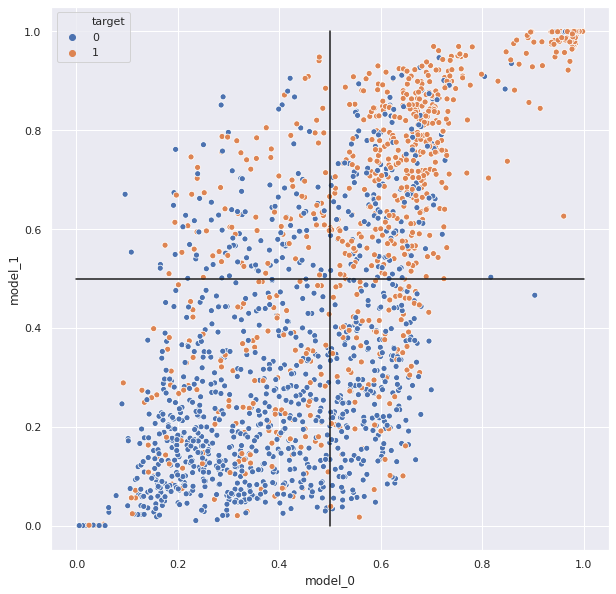

In [34]:
# compare both model by plotting them in a scatter plot
predict_proba = np.zeros([X_val.shape[0],2])
predict_proba[:,0] = Model_Forest.predict_proba(enc_scale.transform(X_val))[:,1]
predict_proba[:,1] = Model_Logistic.predict_proba(enc_scale.transform(X_val))[:,1]
plot_final_proba(predict_proba=predict_proba, y=y_val)

### Explaining the model Starting with the Random Forest

In [35]:
X = X_train[cat_metaData_features+numerical_metaData_features].copy()
X[cat_metaData_features] = OrdinalEncoder().fit_transform(X[cat_metaData_features])

model_metadata = make_pipeline(enc_scale, Model_Forest).fit(X, y_train)

In [36]:
# Feature importance: permutation importance
X = X_val[cat_metaData_features+numerical_metaData_features].copy()

# Have to use OrdinalEncoder() cause PermutationImportance() will internally try to convert 
# the categories into floats (idk why...), and it will fail if I keep the categories as strings
X[cat_metaData_features] = OrdinalEncoder().fit_transform(X[cat_metaData_features]) 

perm_importance = PermutationImportance(model_metadata).fit(X, y_val)
eli5.show_weights(perm_importance, feature_names=cat_metaData_features+numerical_metaData_features)

Weight,Feature
0.0239 ± 0.0084,keyword
0.0196 ± 0.0209,mean_word_length
0.0153 ± 0.0062,difference_2-grams_count
0.0124 ± 0.0051,count_2-grams_in_disaster
0.0064 ± 0.0040,char_count
0.0039 ± 0.0058,count_mentions_in_disaster
0.0028 ± 0.0039,count_2-grams_in_ndisaster
0.0028 ± 0.0074,capital_words_count
0.0026 ± 0.0032,count_mentions_in_ndisaster
0.0022 ± 0.0024,difference_mentions_count


In [37]:
%%time

# Explaining a simgle prediction based the shap library (Shapeley method)
# one could also use eli5.explain_prediction() based on: http://blog.datadive.net/interpreting-random-forests/
# but the onehot encoding makes it too difficult (too many variable to interpret)

end = 100
X = X_train.copy()

model_metadata = make_pipeline(enc_scale, Model_Forest).fit(X, y_train)

#Define ad train the explainer on 100 samples fro the train set
k_explainer = shap.KernelExplainer(model_metadata.predict_proba, X.iloc[:end,:], keep_index=True)

X = X_val.iloc[:10,:].copy() # Define X as the first 10 samples from the validation set

# Use the explainer to compute the shapley value for each sample of X
k_shap_values = k_explainer.shap_values(X)

print(model_metadata.predict_proba(X.iloc[:]))



[[0.34982217 0.65017783]
 [0.34759081 0.65240919]
 [0.73615153 0.26384847]
 [0.82199558 0.17800442]
 [0.49263072 0.50736928]
 [0.29505825 0.70494175]
 [0.78124992 0.21875008]
 [0.71691127 0.28308873]
 [0.64295005 0.35704995]
 [0.33358682 0.66641318]]
CPU times: user 13min 32s, sys: 5.16 s, total: 13min 37s
Wall time: 2min 25s


In [38]:
k_explainer.expected_value[1] # base value

0.47662228243661103

In [39]:
shap.initjs()
sample_nb = 5
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1][sample_nb,:], X.iloc[sample_nb])

In [40]:
X.iloc[sample_nb].loc['text']

'Sinkhole swallows Brooklyn intersection \x89ÛÒ video http://t.co/1yBE5mgZL4 http://t.co/7Zog3DpdU9'

In [41]:
model_metadata.predict_proba(X.iloc[:10,:])[sample_nb,1]

0.7049417473992009

### Explaining the Logistic regression based model

In [42]:
X = X_train[cat_metaData_features+numerical_metaData_features].copy()
X[cat_metaData_features] = OrdinalEncoder().fit_transform(X[cat_metaData_features])

model_metadata = make_pipeline(enc_scale, Model_Logistic).fit(X[cat_metaData_features+numerical_metaData_features], y_train)

In [43]:
# Feature importance: permutation importance
X = X_val[cat_metaData_features+numerical_metaData_features].copy()

# Have to use OrdinalEncoder() cause PermutationImportance() will internally try to convert 
# the categories into floats (idk why...), and it will fail if I keep the categories as strings
X[cat_metaData_features] = OrdinalEncoder().fit_transform(X[cat_metaData_features]) 

perm_importance = PermutationImportance(model_metadata).fit(X, y_val)
eli5.show_weights(perm_importance, feature_names=cat_metaData_features+numerical_metaData_features)

Weight,Feature
0.1426 ± 0.0238,keyword
0.0934 ± 0.0091,char_count
0.0738 ± 0.0118,word_count
0.0296 ± 0.0082,difference_2-grams_count
0.0194 ± 0.0079,count_2-grams_in_disaster
0.0110 ± 0.0050,count_mentions_in_ndisaster
0.0084 ± 0.0027,count_mentions_in_disaster
0.0067 ± 0.0072,unique_word_count
0.0059 ± 0.0068,mention_count
0.0048 ± 0.0041,difference_mentions_count


In [44]:
%%time

# Explaining a simgle prediction based the shap library (Shapeley method)
# one could also use eli5.explain_prediction() based on: http://blog.datadive.net/interpreting-random-forests/
# but the onehot encoding makes it too difficult (too many variable to interpret)

end = 100
X = X_train.copy()

model_metadata = make_pipeline(enc_scale, Model_Logistic).fit(X, y_train)

# Define and train the explainer
k_explainer = shap.KernelExplainer(model_metadata.predict_proba, X.iloc[:end,:], keep_index=True)

X = X_val.iloc[:10,:].copy()

#use the explainer to conpute the shapley value for each example of the sample of X
k_shap_values = k_explainer.shap_values(X)

print(model_metadata.predict_proba(X.iloc[:]))


[[0.32563377 0.67436623]
 [0.13647406 0.86352594]
 [0.83448599 0.16551401]
 [0.84215633 0.15784367]
 [0.92302834 0.07697166]
 [0.14820348 0.85179652]
 [0.49957841 0.50042159]
 [0.65919219 0.34080781]
 [0.97130975 0.02869025]
 [0.23144258 0.76855742]]
CPU times: user 24.5 s, sys: 937 ms, total: 25.4 s
Wall time: 20 s


In [45]:
k_explainer.expected_value[1] # base value

0.46089449472993294

In [46]:
shap.initjs()
sample_nb = 5
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1][sample_nb,:], X.iloc[sample_nb])

In [47]:
X.iloc[sample_nb].loc['text']

'Sinkhole swallows Brooklyn intersection \x89ÛÒ video http://t.co/1yBE5mgZL4 http://t.co/7Zog3DpdU9'

In [48]:
model_metadata.predict_proba(X.iloc[:10,:])[sample_nb,1]

0.8517965209443114

# Neural network classifier on text, using the pretrained bert model

In [49]:
# Load the pretrained layer in bert_layer once and for all in the global scope

try:
    bert_layer = hub.KerasLayer("./bert_en_uncased_L-12_H-768_A-12_2/",
                            trainable=False)
except:
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=False)

The tensorflow.keras.wrappers.scikit_learn.KerasClassifier() wrapper class has a few issues:
- The wrapper calls the method predict_classes() the functional API Keras.Model() does not implement such method: only the
Sequential API does.
- As we'll see later KerasClassifier() does not implement some of the attributes that sklearn classifier implement: for example,
the attribute "_estimator_type" is not implemented by the KerasClassifier() wrapper

In [50]:
class MyModel(K.Model):
    """ This class is mostly the same as tensorflow.keras.Model()
    Main changes:
    - fit() method: modified so that, if there is
        a saved model, then load it. Otherwise, train the model in two steps:

        1. Freeze the Bert layer and train only the top layer over 'epochs1' epochs
        2. Unfreeze the Bert layer, and fine-tune the whole model over 'epochs2' epochs

        In the case where the model is trained, the fit method returns the two histories

    - adding _encode() method:
        The _encode() method convert a pandas.Series of strings into an adapted encoding for
        the neural network.

    - adding the predict_classes() method for compatibility with the tensorflow.keras.wrappers.scikit_learn.KerasClassifier()
        wrapper.
     """
    
    def __init__(self,inputs=None, outputs=None, max_seq_length=80):
        super(MyModel, self).__init__(inputs=inputs, outputs=outputs)
        self.max_seq_length = max_seq_length

        
    def _encode(self, X):
        X = pd.Series(X)
        X = X.copy()
        
        max_seq_length = self.max_seq_length
        texts = X.copy()
        
        vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
        tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = tokenizer.tokenize(text)
            text = text[:max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = max_seq_length - len(input_sequence)

            tokens = tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    def fit(self, x=None, y=None, batch_size=None, epochs1=1, epochs2=1, verbose=1,
        callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
        class_weight=None, sample_weight=None, initial_epoch=0,
        steps_per_epoch=None, validation_steps=None, validation_batch_size=None,
        validation_freq=1, max_queue_size=10, workers=1,
        use_multiprocessing=False, bert_layer_idx=3):
        
        x = self._encode(x)
        
        try:
            # if there is already a saved model use it
            self.load_weights("./weights.best.hdf5")
            self.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
            return None
        except:
            # If no saved model, then train the model
            # Start training the top layers of the model with epochs1 
            self.layers[bert_layer_idx].trainable=False
            self.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
            history1 = super().fit(x=x, y=y, batch_size=batch_size, epochs=epochs1, verbose=1,
                        callbacks=callbacks, validation_split=validation_split, validation_data=validation_data, 
                        shuffle=shuffle, class_weight=class_weight, sample_weight=sample_weight, initial_epoch=initial_epoch,
                        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_batch_size=validation_batch_size,
                        validation_freq=validation_freq, max_queue_size=max_queue_size, workers=workers,
                        use_multiprocessing=use_multiprocessing)

            # Start fine-tuning the model with epochs2
            try:
                self.load_weights("./weights.best.hdf5")  # use the best epoch of the above training if available
            except:
                pass
            self.layers[bert_layer_idx].trainable=True
            self.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
            history2 = super().fit(x=x, y=y, batch_size=batch_size, epochs=epochs2, verbose=1,
                        callbacks=callbacks, validation_split=validation_split, validation_data=validation_data, 
                        shuffle=shuffle, class_weight=class_weight, sample_weight=sample_weight, initial_epoch=initial_epoch,
                        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_batch_size=validation_batch_size,
                        validation_freq=validation_freq, max_queue_size=max_queue_size, workers=workers,
                        use_multiprocessing=use_multiprocessing)


            return (history1, history2)
        
    def evaluate(self, x=None,y=None, batch_size=None, verbose=1, sample_weight=None,
                 steps=None, callbacks=None, max_queue_size=10, workers=1,
                 use_multiprocessing=False, return_dict=False):

        x = self._encode(x)

        return super().evaluate(x=x,y=y, batch_size=batch_size, verbose=verbose, sample_weight=sample_weight,
                 steps=steps, callbacks=callbacks, max_queue_size=max_queue_size, workers=workers,
                 use_multiprocessing=use_multiprocessing, return_dict=return_dict)
        
    def predict_proba(self, x, batch_size=None, verbose=0, steps=None, callbacks=None,
                max_queue_size=10, workers=1, use_multiprocessing=False):


        x = self._encode(x)

        return super().predict(x, batch_size=batch_size, verbose=verbose, steps=steps, callbacks=callbacks,
                max_queue_size=max_queue_size, workers=workers, use_multiprocessing=use_multiprocessing)
    
    def predict_classes(self, x, batch_size=None, verbose=0, steps=None, callbacks=None,
                max_queue_size=10, workers=1, use_multiprocessing=False):
                                
        y_pred = self.predict_proba(x, batch_size=batch_size, verbose=verbose, steps=steps, callbacks=callbacks,
                max_queue_size=max_queue_size, workers=workers, use_multiprocessing=use_multiprocessing)
        
        y_pred = np.array(list(map(lambda b: int(b>0.5), y_pred)))  
        
        return y_pred
        
    def train_on_batch(self, x, y=None, sample_weight=None, class_weight=None, 
                       reset_metrics=True, return_dict=False):

        x = self._encode(x)

        return super().train_om_batch(x, y=y, sample_weight=sample_weight, class_weight=class_weight, 
                                      reset_metrics=reset_metrics, return_dict=return_dict)
        
    def test_on_batch(self, x, y=None,  sample_weight=None, reset_metrics=True, return_dict=False):

        x = self._encode(x)

        return super().test_on_batch(x, y=y, sample_weight=sample_weight, reset_metrics=reset_metrics, 
                                     return_dict=return_dict)
    def predict_on_batch(x):

        x = self._encode(x)

        return super().predict_on_batch(x)
        
        
        
def build_bert_model(max_seq_length=80):

    
    input_word_ids = K.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                           name="input_word_ids")
    input_mask = K.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_mask")
    segment_ids = K.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    inputs = [input_word_ids, input_mask, segment_ids]
    mid = K.layers.Dense(768, activation='relu')(clf_output)
    out = K.layers.Dense(1, activation='sigmoid')(mid)

    model = MyModel(inputs=inputs, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model

Bert_model = KerasClassifier(build_bert_model)   # Creates a Model compatible with the scikit learn API

# This is the callback used to save the best model during training. 
# If there is no already saved model, then pass this call back 
# as an option in the fit method.
best_model = K.callbacks.ModelCheckpoint("./weights.best.hdf5", 
                            monitor="val_loss",
                            verbose=1,
                            save_best_only=True,
                            mode='min'
                            )  


In [51]:
# Bert classifier pipeline

def clean_text(X):
    X = pd.Series(X)
    X = X.copy()
    
    return X.apply(lambda s: clean(s))

Cleaner_text = skl.preprocessing.FunctionTransformer(clean_text)


Bert_clf = Pipeline([('cleaner_text', Cleaner_text),
                     ('bert_model', Bert_model)
                     
            ])

Bert_clf

Pipeline(steps=[('cleaner_text',
                 FunctionTransformer(func=<function clean_text at 0x7fe1ef9f7440>)),
                ('bert_model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe11eeb76d0>)])

In [52]:
Bert_clf.fit(X_train['text'],y_train)

Pipeline(steps=[('cleaner_text',
                 FunctionTransformer(func=<function clean_text at 0x7fe1ef9f7440>)),
                ('bert_model',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe11eeb76d0>)])

In [53]:
Bert_clf.predict(X_train['text'].iloc[:50])

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1])

In [54]:
y_train_pred = Bert_clf.predict(X_train['text'])
y_val_pred = Bert_clf.predict(X_val['text'])

# training score
print("Training scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_train, y_pred=y_train_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_train, y_pred=y_train_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_train, y_pred=y_train_pred))
      )

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred))
      )

Training scores:
 precision=0.87 recall=0.81 f1=0.84

Validation scores:
 precision=0.88 recall=0.80 f1=0.84


### Explain the model: TextExplainer from eli5.lime

In [55]:
%%time
# Explain what the model look at on a text

te = TextExplainer(n_samples=300, position_dependent=True)
doc = "10000 people died yesterday. "
te.fit(doc, Bert_clf.predict_proba)

CPU times: user 13min 14s, sys: 5.86 s, total: 13min 20s
Wall time: 1min 55s


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


TextExplainer(char_based=False,
              clf=SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',
                                random_state=RandomState(MT19937) at 0x7FE20B0C3490),
              n_samples=300, position_dependent=True,
              sampler=MaskingTextSamplers(random_state=RandomState(MT19937) at 0x7FE20B0C3490,
                                          sampler_params=None,
                                          token_pattern='(?u)\\b\\w+\\b',
                                          weights=array([0.7, 0.3])),
              token_pattern='(?u)\\b\\w+\\b')

In [56]:
print(doc)
Bert_clf.predict_proba(doc)

10000 people died yesterday. 


array([[0.12962765, 0.87037235]], dtype=float32)

In [57]:
print(te.metrics_)
te.show_prediction()

{'mean_KL_divergence': 0.02096346425943218, 'score': 0.9224786126022526}


In [58]:
te.show_weights()

Weight?,Feature
+1.533,[2] died
+1.377,[1] people
+0.790,[0] 10000
+0.334,[3] yesterday
-3.001,<BIAS>


# Compare predict proba fort the two model for both the train set and the valdation set

In [214]:
def concat_proba_predict(models, X):
    try:
        iter(models)
    except:
        raise TypeError("{} is not iterable".format(type(models)))
    else:
        proba_predictions = pd.DataFrame()
        for idx, model in enumerate(models):
            name = "predict_proba_model_{}".format(idx)
            proba_predictions[name] = model.predict_proba(X)[:,1]
        return proba_predictions

In [215]:
# include the StandardScaler in the Model_Forest


Model_Forest_clf = Pipeline([('enc_scale', enc_scale),
                             ('forest_clf', Model_Forest)
                            ])

Model_Logistic_clf = Pipeline([('enc_scale', enc_scale),
                             ('logistic_clf', Model_Logistic)
                              ])


# include a column selector in the Bert_clf
def column_slector(X, column=None):
    X = pd.DataFrame(X); X = X.copy()
    
    if type(column) not in [str, int]:
        raise TypeError('{} is not str or int'.format(type(column)))
        
    return X[column]

Column_selector = skl.preprocessing.FunctionTransformer(column_slector, kw_args={'column':'text'})

Bert_clf_col_select = Pipeline([('column_selector',Column_selector),
                                ('bert_clf',Bert_clf)
                               ])

In [216]:
models = [Bert_clf_col_select, Model_Forest_clf, Model_Logistic_clf]

predict_proba_train = np.array(concat_proba_predict(models, X_train).iloc[:,:])

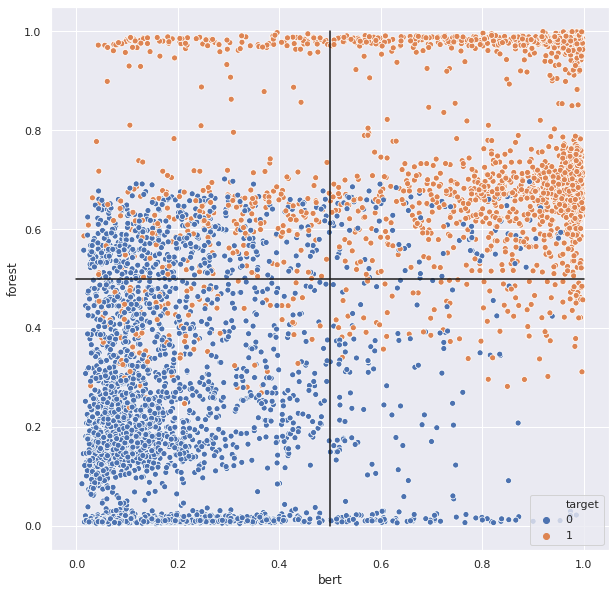

In [217]:
# plot bert vs forest in train 
data = pd.DataFrame()
end = None
data['bert'] = predict_proba_train[:end,0]
data['forest'] = predict_proba_train[:end,1]
data['target'] = y_train.reset_index(drop=True).iloc[:end]
 
plt.figure(figsize=(10,10))
sns.scatterplot(x='bert', y='forest', data=data, hue='target')

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
plt.plot(x, 0.5*np.ones(100), c='k')
plt.plot(0.5*np.ones(100), y, c='k')

In [226]:
models = [Bert_clf_col_select, Model_Forest_clf, Model_Logistic_clf]

predict_proba_val = np.array(concat_proba_predict(models, X_val).iloc[:,:])

KeyboardInterrupt: 

(1904, 2)


Text(0, 0.5, 'Forest')

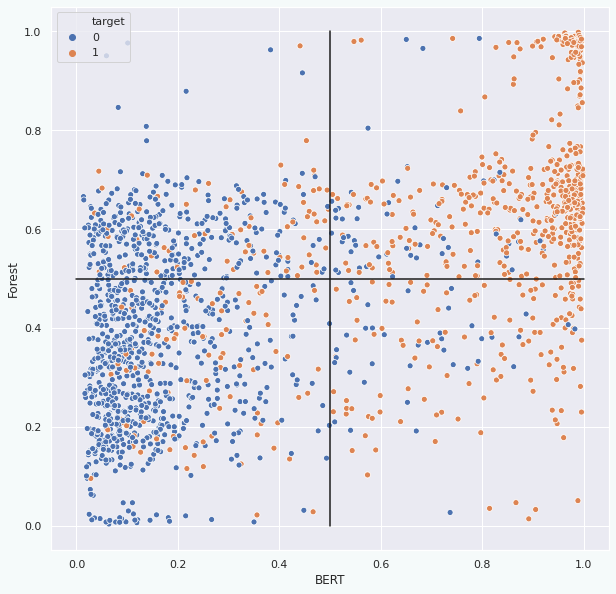

In [236]:
# plot bert vs forest in val
plot_final_proba(predict_proba_val[:,[0,1]], y_val)
plt.xlabel('BERT')
plt.ylabel('Forest')

(1904, 2)


Text(0, 0.5, 'Logistic')

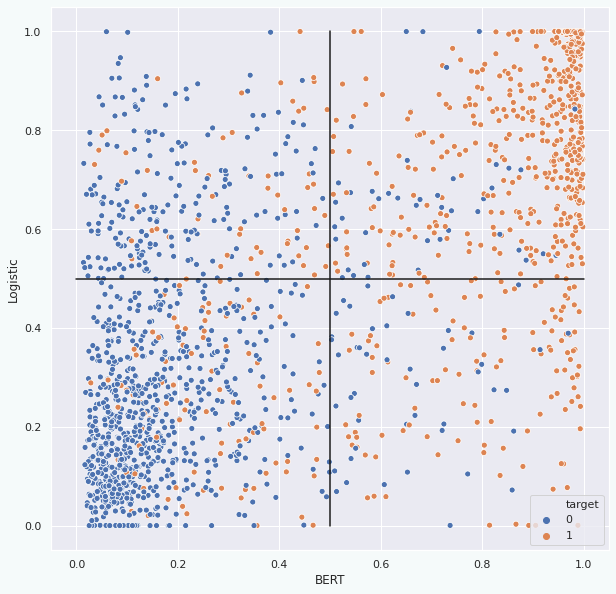

In [237]:
# plot bert vs logistic in val
plot_final_proba(predict_proba_val[:,[0,2]], y_val)
plt.xlabel('BERT')
plt.ylabel('Logistic')

## Improve result by combining both model

In [232]:
final_model_for = RandomForestClassifier(n_estimators=50, max_depth=3, class_weight='balanced').fit(predict_proba_train[:,[0,1]], y_train)

In [233]:
# score predict together final = Rnd Forest


y_tain_pred = final_model_for.predict(predict_proba_train[:,[0,1]])
y_val_pred = final_model_for.predict(predict_proba_val[:,[0,1]])

# training score
print("Training scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_train, y_pred=y_train_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_train, y_pred=y_train_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_train, y_pred=y_train_pred))
      )

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred))
      )

Training scores:
 precision=0.87 recall=0.81 f1=0.84

Validation scores:
 precision=0.82 recall=0.78 f1=0.80


### Explain what the final_model_for does by plotting the heatmap ofthe predicted probability with the prediction of the two other models for the validation set

(1904, 3)


Text(0, 0.5, 'Probability attributed by the Forest based model')

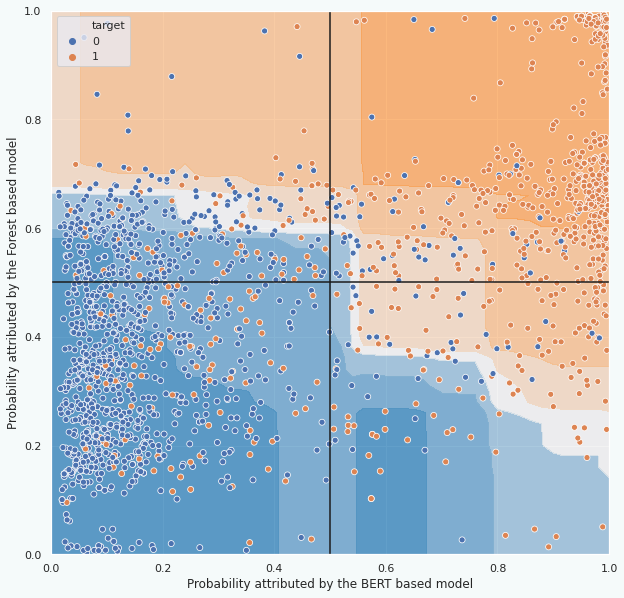

In [234]:
plot_final_proba(predict_proba_val, y_val, final_model_for)
plt.xlabel("Probability attributed by the BERT based model")
plt.ylabel("Probability attributed by the Forest based model")

# Include the models into pipelines

## Define a bunch of tranformers

In [93]:
# This cannot be done in a tranformer since this operation only applies to the training set, not the test set.

def mislabel_fix(X, y, text_col):
    X = pd.DataFrame(X)
    y = pd.Series(y)
    X = X.copy()
    y = y.copy()

    if type(text_col) not in [int, str]:
        raise TypeError('{} is not str or int'.format(type(text_col)))
    if type(text_col) == int:
        text_col = X.columns[text_col]

    X['y'] = y

    X_mislabeled = X.loc[:,[text_col, 'y']].groupby([text_col]).nunique().sort_values(by='y', ascending=False)
    X_mislabeled = X_mislabeled.loc[X_mislabeled['y']>1]

    mislabeled_bool = X[text_col].map(lambda s: s in list(X_mislabeled.index)) ; del X_mislabeled

    new_target = X.loc[:,[text_col, 'y']].groupby(text_col).mean()  # use voting strategy to relabel the mislabeled tweet
    new_target = new_target['y'].map(lambda avg: int(avg>0.5))  # use voting strategy to relabel the mislabeled tweet

    # if mislabeld then 'new_target' otherwise 'target'
    y = np.array(new_target.loc[data_set[text_col]])*np.array(mislabeled_bool)+np.array(X['y'])*(1-np.array(mislabeled_bool))

    return y

In [109]:
# reload the data in its original form: before cleaning and feature extraction

data_set2 = pd.read_csv('./train.csv').drop('location', axis=1)
test_set2 = pd.read_csv('./test.csv').drop('location', axis=1)


# checking mislabeled text: identical tweets labeled differently


data_set2['target_corrected'] = mislabel_fix(data_set2, data_set2['target'], 'text')

In [110]:
# Transformer to fill Nan values

def Nan_Categoritcal_fill(X, columns=['keyword']):
    X = pd.DataFrame(X)
    X = X.copy()
    def remove_Qmarks(s):
        if type(s)==type('') and bool(re.search("[?]", s)):
            s = np.nan
        return s

    for column in columns:
        X[column] = data_set[column].map(lambda s: remove_Qmarks(s) ) 

    dictionary = dict()
    for column in columns:
        dictionary[column] = 'no_'+column
        
    X = X.fillna(value=dictionary)
    
    return X

Categorical_Nan_Filler = skl.preprocessing.FunctionTransformer(Nan_Categoritcal_fill)
    
Categorical_Nan_Filler.transform(data_set2).head(3)

,id,keyword,text,target,target_corrected,text_cleaned
0,1,no_keyword,Our Deeds are the Reason of this #earthquake M...,1,1,our deeds are the reason of this # earthquake...
1,4,no_keyword,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask . canada
2,5,no_keyword,All residents asked to 'shelter in place' are ...,1,1,all residents asked to ' shelter in place ' ...


In [111]:
# Transformer for cleaning text data

def clean_text(X):
    X = pd.Series(X)
    X = X.copy()
    
    return X.apply(lambda s: clean(s))

def clean_keywords(X, column):
    X = pd.DataFrame(X)
    X = X.copy()
    
    if type(column)!=int and type(column)!=str:
        raise TypeError("{} is not int or str".format(type(column)))
    
    if type(column)==int:
        column = X.columns[column]

    X[column] = X[column].apply(lambda s: clean(s))
    
    return X

Cleaner_text = skl.preprocessing.FunctionTransformer(clean_text)
Cleaner_keywords = skl.preprocessing.FunctionTransformer(clean_keywords, kw_args={'column' : 'keyword'})

In [165]:
# Transformer that will add features: "feature extraction"

class AddFeaturesTransformer(skl.base.BaseEstimator, skl.base.TransformerMixin):
    def __init__(self, column, ngram__n = 2, n_ngrams=100):
        super().__init__()
        self.n = ngram__n
        self.n_ngrams = n_ngrams
        self.mention_counter = CountMentionsInClass()
        self.ngram_counter = CountTopNGramsInClass(ngram__n, n_ngrams)
        self.column = column
        
    def fit(self, X, y, column = None):
        X = pd.DataFrame(X) ; X = X.copy()
        y = pd.Series(y) ; y = y.copy()
        
        if column is None: 
            column=self.column
        
        if type(column) not in [int, str]:
            raise TypeError("{} is not int or str".format(type(column)))
        
        if type(column)==int:
            column = X.columns[column]
            
        self.mention_counter.fit(X, y, column=column)
        self.ngram_counter.fit(X, y, column=column)
        
        return self
    
    def transform(self, X, column=None):
        X = pd.DataFrame(X) ; X = X.copy()
        
        if column is None: 
            column=self.column
        
        if type(column) not in [int, str]:
            raise TypeError("{} is not int or str".format(type(column)))
        
        if type(column)==int:
            column = X.columns[column]
        
        # count the number of hashtags
        X['hastags_count'] = X[column].map(lambda text: sum([char=='#' for char in text]) )
        # count all cap words
        X['capital_words_count'] = X[column].map( lambda text: sum( [word==word.upper() for word in text.split()] ) )
        # word_count
        X['word_count'] = X[column].apply(lambda x: len(str(x).split()))
        # unique_word_count
        X['unique_word_count'] = X[column].apply(lambda x: len(set(str(x).split())))
        # url_count
        X['url_count'] = X[column].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
        # mean_word_length
        X['mean_word_length'] = X[column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
        # char_count
        X['char_count'] = X[column].apply(lambda x: len(str(x)))
        # punctuation_count
        X['punctuation_count'] = X[column].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
        # mention_count
        X['mention_count'] = X[column].apply(lambda x: len([c for c in str(x) if c == '@']))
        # count mentions in target classes
        X = self.mention_counter.transform(X, column=column)
        # compute de difference between  mentions in disasters and mentions not in disasters
        X["difference_mentions_count"] = X["count_mentions_in_disaster"] - X["count_mentions_in_ndisaster"]
        # count ngrams in target classes
        X = self.ngram_counter.transform(X, column=column)
        # compute de difference between ngrams in disasters and mentions not in disasters
        X[f"difference_{self.n}-grams_count"] = X[f"count_{self.n}-grams_in_disaster"] - X[f"count_{self.n}-grams_in_ndisaster"]
        
        return X
    
    def fit_transform(self, X, y, column=None):
        
        if column is None: 
            column=self.column
            
        return super().fit_transform(X, y, column=column)




Feature_additioner = AddFeaturesTransformer(column='text')


In [166]:
# Define a column selector transformer for the Bert_model so that it can take a Dataframe as input

def column_slector(X, column=None):
    X = pd.DataFrame(X); X = X.copy()
    
    if type(column) not in [str, int]:
        raise TypeError('{} is not str or int'.format(type(column)))
        
    return X[column]

Column_selector = skl.preprocessing.FunctionTransformer(column_slector, kw_args={'column':'text'})

In [167]:
# Define the Bert model pipeline that takes a data frame as input

Bert_model = KerasClassifier(build_bert_model)

Cleaner_text = skl.preprocessing.FunctionTransformer(clean_text)


Bert_clf = Pipeline([('cleaner_text', Cleaner_text),
                     ('bert_model', Bert_model)          
                    ])

Bert_clf_with_col_select = Pipeline([('column_selector', Column_selector),('bert_clf',Bert_clf)])


In [168]:
# Create the Pipeline for the meta-data based classifier

# Preprocessor pipeline
preprocessor = Pipeline([('nan_filler', Categorical_Nan_Filler),
                         ('cleaner_keywords', Cleaner_keywords),
                         ('feature_additioner', Feature_additioner)
                ])

# Meta data Classifier pipeline
encode_scale = ColumnTransformer([('scaler',StandardScaler(), numerical_metaData_features),
                                  ('enc', OneHotEncoder(handle_unknown='ignore'), cat_metaData_features)]).fit(X_train,y_train)


metaData_clf = Pipeline([('preprocessor', preprocessor),
                         ('encode_scale', encode_scale),
                         ('rand_forest', RandomForestClassifier(max_depth=6, class_weight='balanced'))]
               )

KerasClassifier() does not implement the attribute "_estimator_type" (see next cell) which makes the fit method of sklearn.ensemble.StackingClassifier() fail when checking this attribute. Therefore I write my own stacking classifier class.

In [171]:
print(getattr(Bert_model, "_estimator_type", 'no such attribute'),"\n",
      getattr(Bert_clf_with_col_select, "_estimator_type", 'no such attribute'))

no such attribute 
 no such attribute


In [172]:
# Define my own stacking class, to stack the two pipelines
# It does something similar to sklearn.ensemble.StackingClassifier()

class MyStackingClassifier:
    
    def __init__(self, estimators=None, final_estimator=LogisticRegression(class_weight='balanced')):
        try:
            iter(estimators)
        except:
            raise TypeError("{} is not iterable".format(type(estimators)))
        else:
            self.final_estimator = final_estimator
            self.estimators = []
            self.names = []
            for name, estimator in estimators:
                if type(name)==str:
                    self.estimators.append(estimator)
                    self.names.append(name)
                else:
                    raise TypeError("'name' must be a string")
                    
                    
    def _check_fit_params(self, **fit_params):
        fit_params_estimators = {name: {} for name, estimator in zip(self.names, self.estimators)
                            if estimator is not None}
        for pname, pval in fit_params.items():
            if '__' not in pname:
                raise ValueError(
                    "Pipeline.fit does not accept the {} parameter. "
                    "You can pass parameters to specific steps of your "
                    "pipeline using the stepname__parameter format, e.g. "
                    "`Pipeline.fit(X, y, logisticregression__sample_weight"
                    "=sample_weight)`.".format(pname))
            estimator, param = pname.split('__', 1)
            fit_params_estimators[estimator][param] = pval
        return fit_params_estimators
        
    
    def fit(self, X, y, plot=True, **fit_params):
        X = pd.DataFrame(X)
        y = pd.Series(y)
        n_estimators = len(self.estimators)
        
        fit_params_estimators = self._check_fit_params(**fit_params)
        
        # fitting the base estimators
        self.estimators = [estimator.fit(X, y, **fit_params_estimators[name]) for name, estimator in zip(self.names, self.estimators)]
        
        # fitting the final estimator
        predict_proba = np.zeros([X.shape[0], n_estimators])        
        for idx, estimator in enumerate(self.estimators):
            print("Base estimator {}/{}".format(idx+1, n_estimators))
            predict_proba[:,idx] =  estimator.predict_proba(X)[:,1]
            
            
        self.final_estimator.fit(predict_proba, y)
        
        if plot:
            plot_final_proba(predict_proba, y, self.final_estimator)
        
        return self
    
    
    def predict_proba(self,X, **pred_proba_params):
        X = pd.DataFrame(X)
        n_estimators = len(self.estimators)
        
        predict_proba = np.zeros([X.shape[0], n_estimators])        
        for idx, estimator in enumerate(self.estimators):
            predict_proba[:,idx] = estimator.predict_proba(X)[:,1] 
            
        return self.final_estimator.predict_proba(predict_proba)
        
    
    def predict(self,X, **pred_params):
        X = pd.DataFrame(X)
        n_estimators = len(self.estimators)
        
        pred_params_estimators = self._check_fit_params(**pred_params)
        
        predict_proba = np.zeros([X.shape[0], n_estimators])        
        for idx, estimator in enumerate(self.estimators):
            predict_proba[:,idx] = estimator.predict_proba(X)[:,1]
            
        return self.final_estimator.predict(predict_proba)

In [173]:
# Define the final classifier

final_clf = MyStackingClassifier(estimators=[('Bert_clf', Bert_clf_with_col_select), ('rnd_forest', metaData_clf)],
                                final_estimator=RandomForestClassifier(max_depth=3, class_weight='balanced'))


In [174]:
# Define X_val2 etc. such that they correspond the the same rows of the data set as X_val etc. do

columns = [column for column in data_set2.columns if column not in ['target', 'target_corrected']]

idx_val = X_val.index.tolist()
idx_train = X_train.index.tolist()

X_val2 = data_set2.loc[idx_val, columns]
X_train2 = data_set2.loc[idx_train, columns]

y_val2 = data_set2.loc[idx_val,'target_corrected']
y_train2 = data_set2.loc[idx_train,'target_corrected']

Base estimator 1/2
Base estimator 2/2
(5709, 2)


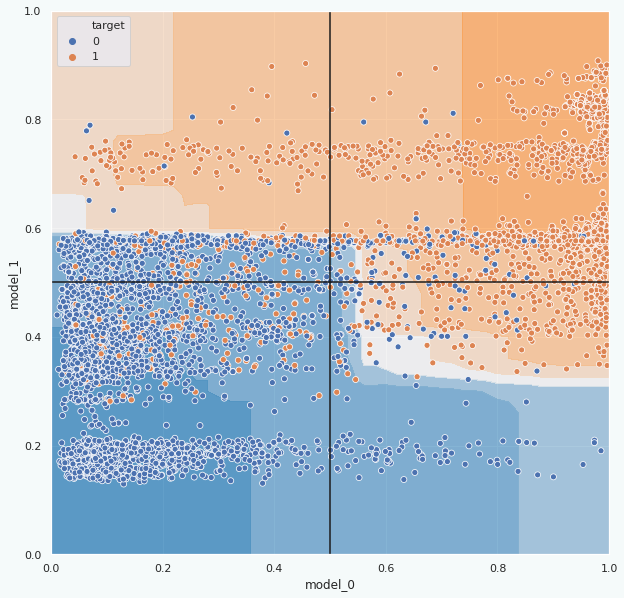

In [175]:
final_clf.fit(X_train2, y_train2)

In [176]:
y_val_pred = final_clf.predict(X_val2)

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred))
      )


Validation scores:
 precision=0.87 recall=0.79 f1=0.83


In [177]:
y_val_pred2 = final_clf.estimators[1].predict(X_val2)

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred2)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred2)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred2))
      )


Validation scores:
 precision=0.60 recall=0.70 f1=0.65


In [178]:
y_val_pred3 = Bert_clf_with_col_select.predict(X_val2)

# validation score
print("\nValidation scores:\n",
      "precision={:.2f}".format(skl.metrics.precision_score(y_true=y_val, y_pred=y_val_pred3)),
      "recall={:.2f}".format(skl.metrics.recall_score(y_true=y_val, y_pred=y_val_pred3)),
      "f1={:.2f}".format(skl.metrics.f1_score(y_true=y_val, y_pred=y_val_pred3))
      )


Validation scores:
 precision=0.88 recall=0.80 f1=0.84


In [231]:
end = 1000
plot_final_proba(np.array(list(zip(final_clf.estimators[0].predict_proba(X_val2[:end])[:,1], 
                                   final_clf.estimators[1].predict_proba(X_val2[:end])[:,1]))),
                 y_val, final_clf.final_estimator)
plt.show()

KeyboardInterrupt: 

In [210]:
# Look at the tweets where the model was wrong

indices = [i for i in range(len(y_val2)) if y_val_pred[i] != y_val2.iloc[i]]

end = 20

for tweet, idx in zip(X_val2['text'].loc[y_val_pred != y_val2].iloc[:end], indices):
    print(f'pred = {y_val_pred[idx]}', f'true = {y_val2.iloc[idx]}  ', tweet)

pred = 0 true = 1   @todd_calfee so @mattburgener wanted to see that info on blight u got
pred = 0 true = 1   I WAS PEACEFULLY SITTING IN MY ROOM AND I HEARD THIS LOUD BANG OF SOMETHING FALLING
pred = 0 true = 1   TodayÛªs storm will pass; let tomorrowÛªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.
pred = 0 true = 1   @TheHammers_ @tonycottee1986 alsowhat if some of the 1st team players got injured?Then Bilic would get slated for playing themhe can't win
pred = 0 true = 1   #hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J2aQs5loxu #prebreak #best
pred = 1 true = 0   Haley Lu Richardson Fights for Water in The Last Survivors (Review) http://t.co/oObSCFOKtQ
pred = 0 true = 1   My precious olive tree lost this battle...another crazy windstorm in #yyc! @weathernetwork http://t.co/N00DVXEga2
pred = 0 true = 1   I can probably skip on these basic life maintenance things for a few days. (cut to burning